In [1]:
from goatools.obo_parser import GODag
from tqdm import tqdm
import pickle

In [2]:
go_dag = GODag("/home/shervin/Thesis/Code/storage/ontology/go-basic.obo")

/home/shervin/Thesis/Code/storage/ontology/go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms


In [3]:
go_dag['GO:0006915']

GOTerm('GO:0006915'):
  id:GO:0006915
  item_id:GO:0006915
  name:apoptotic process
  namespace:biological_process
  _parents: 1 items
    GO:0012501
  parents: 1 items
    GO:0012501	level-03	depth-03	programmed cell death [biological_process]
  children: 19 items
  level:4
  depth:4
  is_obsolete:False
  alt_ids: 2 items
    GO:0008632
    GO:0006917

In [4]:
len(go_dag)

43544

In [5]:
bp_dag = {}
for go_id in tqdm(go_dag):
    go_term = go_dag[go_id]
    if go_term.namespace == 'biological_process':
        bp_dag[go_id] = go_term

100%|██████████| 43544/43544 [00:00<00:00, 1641546.06it/s]


In [6]:
levels = {}
for go_id in tqdm(bp_dag):
    go_term = bp_dag[go_id]
    level = go_term.level
    if level in levels:
        levels[level].append(go_term)
    else:
        levels[level] = [go_term]

100%|██████████| 28063/28063 [00:00<00:00, 2147661.81it/s]


In [7]:
len(levels)

14

In [8]:
for level in range(len(levels)):
    print(f'level {level} with {len(levels[level])} go terms.')

level 0 with 4 go terms.
level 1 with 32 go terms.
level 2 with 375 go terms.
level 3 with 2245 go terms.
level 4 with 4817 go terms.
level 5 with 6609 go terms.
level 6 with 6293 go terms.
level 7 with 4706 go terms.
level 8 with 2017 go terms.
level 9 with 606 go terms.
level 10 with 257 go terms.
level 11 with 81 go terms.
level 12 with 15 go terms.
level 13 with 6 go terms.


In [81]:
2000 * 4817 + 4817 *2245  + 2245 * 375

21290040

In [13]:
from goatools.anno.gaf_reader import GafReader

gaf_reader = GafReader('/home/shervin/Thesis/Code/storage/ontology/goa_human.gaf')

HMS:0:00:11.318945 969,176 annotations READ: /home/shervin/Thesis/Code/storage/ontology/goa_human.gaf 


In [14]:
ns2assc = gaf_reader.get_ns2assc()

In [15]:
ns2assc['BP']

{'A0A075B6H5': {'GO:0002376', 'GO:0007166'},
 'A0A075B6H7': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6H8': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6H9': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I0': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I1': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I3': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I4': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I6': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I7': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6I9': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6J1': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6J2': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6J6': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6J9': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6K0': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6K2': {'GO:0002250', 'GO:0002376', 'GO:0006955'},
 'A0A075B6K

As it's obvious in above the keys are ProtIDs so I need to have a mapping between ENSMBEL gene ids and ProtIDs

# Create the mapping between Gene ENSMBEL ids and ProtIDs

#### Create a list of all ensemble ids in both TCGA‌ and GDSC

In [ ]:
with open('/home/shervin/Thesis/Code/storage/tcga_temp/gene_expression/data.pkl', 'rb') as f:
    tcga_data = pickle.load(f)

with open('/home/shervin/Thesis/Code/storage/gdsc_temp/gene_expression/data.pkl', 'rb') as f:
    gdsc_data = pickle.load(f)

In [ ]:
tcga_gene_ids = list(map(lambda x: x.split('.')[0], tcga_data['gene_ids']))
gdsc_gene_ids = list(gdsc_data['gene_ids'])

In [ ]:
all_gene_ids = sorted(list(set(tcga_gene_ids + gdsc_gene_ids)))

In [ ]:
len(all_gene_ids)

In [ ]:
import mygene, time
from tqdm import tqdm

mg = mygene.MyGeneInfo()
batch_size = 100
mapping = {}

for i in tqdm(range(0, len(all_gene_ids), batch_size)):
    ensembl_ids = all_gene_ids[i:i+batch_size]
    res = mg.querymany(ensembl_ids,
                       scopes='ensembl.gene',
                       fields='uniprot',
                       species='human')
    for r in res:
        ensembl_id = r['query']
        if r.get('notfound'):
            print(f"Not found: {ensembl_id}")
            continue
        uniprot_info = r.get('uniprot', {})
        sp = uniprot_info.get('Swiss-Prot')
        if sp:
            if isinstance(sp, list):
                mapping[ensembl_id] = sp[0]
            else:
                mapping[ensembl_id] = sp
        else:
            print(f"Failed to retrieve ProtID for {ensembl_id}")
    time.sleep(0.5)  # optional


In [ ]:
with open('/home/shervin/Thesis/Code/storage/ensmble_id_to_swiss_prot.pkl','wb') as f:
    pickle.dump(mapping, f)

# Lets see how I can map genes to level 4

In [17]:
with open('/home/shervin/Thesis/Code/storage/ensmble_id_to_swiss_prot.pkl','rb') as f:
    mapping = pickle.load(f)

In [26]:
# lets count how many genes do not have go terms
count = 0
a = []
for gene_id, prot_id in mapping.items():
    if prot_id in ns2assc['BP']:
        go_terms = ns2assc['BP'][prot_id]
        a.append(max(bp_dag[go_term].level for go_term in go_terms))  
    else:
        count+=1
    

In [30]:
from collections import Counter
c = Counter(a)
c

Counter({7: 3609,
         6: 2975,
         8: 2709,
         9: 2165,
         10: 2042,
         5: 1621,
         4: 862,
         11: 464,
         3: 409,
         2: 151,
         12: 21,
         13: 18,
         1: 1})

In [61]:
def get_level4_terms_all_parents(go_id, godag, target_level=4):
    """
    Return all level-4 GO terms that are reachable from go_id,
    considering all ancestors (if level >=4) or all descendants (if level <4).
    """
    term = godag[go_id]
    
    if term.level >= target_level:
        # climb ancestors until level 4, consider all paths
        level4_terms = set()
        stack = [term]
        while stack:
            current = stack.pop()
            if current.level == target_level:
                level4_terms.add(current.id)
            elif current.level > target_level:
                # add all parents
                stack.extend(current.parents)
        return list(level4_terms)
    
    else:
        # propagate down: find all descendants at level 4
        level4_descendants = set()
        for t in godag.values():
            if t.level == target_level:
                ancestors = set(t.get_all_parents())  # fix here
                if go_id in ancestors:
                    level4_descendants.add(t.id)
        return list(level4_descendants)


In [47]:
gene_go_terms_in_level_4 = {}
go_terms_genes = {}
for gene_id, prot_id in tqdm(mapping.items()):
    if prot_id in ns2assc['BP']:
        go_terms = ns2assc['BP'][prot_id]
        levels = [bp_dag[go_term].level for go_term in go_terms]
        level_4_terms = [get_level4_terms_all_parents(go_term, bp_dag) for go_term in go_terms]
        level_4_terms = list(set([go_term for _go_terms in level_4_terms for go_term in _go_terms]))
        gene_go_terms_in_level_4[gene_id] = level_4_terms
        for go_term in level_4_terms:
            go_terms_genes[go_term] = go_terms_genes.get(go_term,[]) + [gene_id]

100%|██████████| 19227/19227 [07:21<00:00, 43.55it/s] 


In [50]:
for go_term, genes in go_terms_genes.items():
    print(go_term, len(genes))

GO:0048523 4955
GO:0009966 3019
GO:0048584 2051
GO:0080134 899
GO:0002831 431
GO:0048585 1697
GO:0002683 561
GO:0032101 960
GO:0023056 1742
GO:0048522 5740
GO:0010646 2715
GO:0023057 1444
GO:0050776 715
GO:0051093 952
GO:0022603 726
GO:0042127 1653
GO:0003382 306
GO:2000026 1067
GO:0051241 1132
GO:0036293 12
GO:0071454 67
GO:1990910 196
GO:0090519 23
GO:0036296 13
GO:0070483 196
GO:0090407 580
GO:0008610 610
GO:0019538 2914
GO:0003032 11
GO:0009225 75
GO:0006796 1256
GO:0019637 784
GO:1901137 465
GO:0071456 342
GO:0071455 84
GO:0043412 1889
GO:0180047 47
GO:0090650 121
GO:0043413 231
GO:0006629 1157
GO:0006066 273
GO:1903509 117
GO:0071453 21
GO:0097502 48
GO:0002548 1134
GO:0097628 332
GO:0060326 525
GO:0002233 1123
GO:0044319 347
GO:0071621 1141
GO:0097531 972
GO:0061457 332
GO:0030182 1334
GO:0001764 461
GO:0002408 1125
GO:0021535 343
GO:0060973 347
GO:0021515 1076
GO:0160131 332
GO:1902766 332
GO:0002407 1124
GO:0072676 997
GO:0035701 338
GO:0035696 977
GO:0035703 971
GO:0048666 23

In [52]:
sum([len(v) for _,v in go_terms_genes.items()])

1096502

In [54]:
with open('/home/shervin/Thesis/Code/storage/gene_expressions_cleaned/tcga.pkl','rb') as f:
    tcga_cleaned = pickle.load(f)

In [55]:
tcga_cleaned['gene_ids']

['ENSG00000001617',
 'ENSG00000002549',
 'ENSG00000002586',
 'ENSG00000002834',
 'ENSG00000004059',
 'ENSG00000004399',
 'ENSG00000004455',
 'ENSG00000004779',
 'ENSG00000004799',
 'ENSG00000004961',
 'ENSG00000005022',
 'ENSG00000005075',
 'ENSG00000005249',
 'ENSG00000005893',
 'ENSG00000006007',
 'ENSG00000006042',
 'ENSG00000006118',
 'ENSG00000006125',
 'ENSG00000006327',
 'ENSG00000006625',
 'ENSG00000006704',
 'ENSG00000006712',
 'ENSG00000006831',
 'ENSG00000007080',
 'ENSG00000007202',
 'ENSG00000007255',
 'ENSG00000007376',
 'ENSG00000007520',
 'ENSG00000008018',
 'ENSG00000008083',
 'ENSG00000008282',
 'ENSG00000008283',
 'ENSG00000008394',
 'ENSG00000008441',
 'ENSG00000008988',
 'ENSG00000009307',
 'ENSG00000009954',
 'ENSG00000010017',
 'ENSG00000010165',
 'ENSG00000010256',
 'ENSG00000010278',
 'ENSG00000010292',
 'ENSG00000011007',
 'ENSG00000011028',
 'ENSG00000011260',
 'ENSG00000011304',
 'ENSG00000011454',
 'ENSG00000011465',
 'ENSG00000012223',
 'ENSG00000012983',


In [66]:
gene_go_terms_in_level_4 = {}
go_terms_genes = {}
for gene_id in tqdm(tcga_cleaned['gene_ids']):
    if gene_id in mapping:
        prot_id = mapping[gene_id]
        if prot_id in ns2assc['BP']:
            go_terms = ns2assc['BP'][prot_id]
            levels = [bp_dag[go_term].level for go_term in go_terms]
            level_4_terms = [get_level4_terms_all_parents(go_term, bp_dag, target_level=3) for go_term in go_terms]
            level_4_terms = list(set([go_term for _go_terms in level_4_terms for go_term in _go_terms]))
            gene_go_terms_in_level_4[gene_id] = level_4_terms
            for go_term in level_4_terms:
                go_terms_genes[go_term] = go_terms_genes.get(go_term,[]) + [gene_id]
    else:
        print(f'{gene_id} not in mapping...')

 57%|█████▋    | 1001/1759 [00:02<00:01, 424.07it/s]

ENSG00000132967 not in mapping...


 65%|██████▌   | 1152/1759 [00:02<00:01, 468.36it/s]

ENSG00000153113 not in mapping...


 78%|███████▊  | 1366/1759 [00:03<00:00, 497.55it/s]

ENSG00000175061 not in mapping...
ENSG00000177410 not in mapping...


 83%|████████▎ | 1466/1759 [00:03<00:00, 474.19it/s]

ENSG00000186493 not in mapping...
ENSG00000196205 not in mapping...
ENSG00000196922 not in mapping...


 89%|████████▉ | 1562/1759 [00:03<00:00, 455.92it/s]

ENSG00000197180 not in mapping...
ENSG00000198618 not in mapping...
ENSG00000203875 not in mapping...


 94%|█████████▍| 1652/1759 [00:03<00:00, 409.72it/s]

ENSG00000204387 not in mapping...
ENSG00000210082 not in mapping...
ENSG00000211459 not in mapping...
ENSG00000211592 not in mapping...
ENSG00000211895 not in mapping...
ENSG00000211896 not in mapping...
ENSG00000211899 not in mapping...
ENSG00000213178 not in mapping...
ENSG00000225285 not in mapping...
ENSG00000225630 not in mapping...
ENSG00000225648 not in mapping...
ENSG00000227081 not in mapping...
ENSG00000227097 not in mapping...
ENSG00000232573 not in mapping...
ENSG00000232956 not in mapping...
ENSG00000233762 not in mapping...
ENSG00000233834 not in mapping...
ENSG00000234664 not in mapping...
ENSG00000234741 not in mapping...
ENSG00000234851 not in mapping...
ENSG00000235655 not in mapping...
ENSG00000236439 not in mapping...
ENSG00000236552 not in mapping...
ENSG00000236824 not in mapping...
ENSG00000237973 not in mapping...
ENSG00000240342 not in mapping...


100%|██████████| 1759/1759 [00:03<00:00, 440.30it/s]

ENSG00000244398 not in mapping...
ENSG00000245532 not in mapping...
ENSG00000245910 not in mapping...
ENSG00000248527 not in mapping...
ENSG00000251022 not in mapping...
ENSG00000251562 not in mapping...
ENSG00000254635 not in mapping...
ENSG00000255198 not in mapping...
ENSG00000255717 not in mapping...
ENSG00000259781 not in mapping...
ENSG00000260032 not in mapping...
ENSG00000260260 not in mapping...
ENSG00000269893 not in mapping...
ENSG00000274173 not in mapping...
ENSG00000276168 not in mapping...
ENSG00000277734 not in mapping...
ENSG00000278845 not in mapping...


In [67]:
for go_term, genes in go_terms_genes.items():
    print(go_term, len(genes))

GO:0023019 118
GO:0033313 116
GO:0035556 275
GO:0007210 115
GO:0040012 127
GO:0001402 115
GO:0007166 243
GO:0140626 115
GO:0038183 115
GO:0071588 115
GO:0098928 115
GO:0055095 116
GO:0050794 1013
GO:0009755 133
GO:0048588 15
GO:0009756 115
GO:0048519 617
GO:0050793 267
GO:0009864 184
GO:0021604 4
GO:0002764 131
GO:0009863 115
GO:0009888 61
GO:0016043 608
GO:0010017 115
GO:0140507 118
GO:0032005 115
GO:0048583 426
GO:0009866 184
GO:0040008 78
GO:0042699 143
GO:0048731 82
GO:0016477 82
GO:0010850 115
GO:0002433 184
GO:0023041 115
GO:0060863 115
GO:0038034 120
GO:0006935 19
GO:0060560 17
GO:0090520 117
GO:0097527 115
GO:0007186 136
GO:0007602 116
GO:0106167 115
GO:0051239 335
GO:1990806 117
GO:0098926 116
GO:1903831 115
GO:0002757 197
GO:0021675 6
GO:0048518 711
GO:0097190 161
GO:0044238 843
GO:0043170 661
GO:0120078 62
GO:0033627 61
GO:0036350 61
GO:0045123 88
GO:0060519 61
GO:0098609 92
GO:0003392 61
GO:0031589 70
GO:0071674 98
GO:0002682 168
GO:0036349 61
GO:0061343 62
GO:0034220 125
G

In [68]:
len(go_terms_genes)

1487

In [69]:
import torch

In [72]:
a = torch.rand(len(go_terms_genes), len(tcga_cleaned['gene_ids']))

In [ ]:
a.shape

torch.Size([1487, 1759])

In [76]:
import matplotlib.pyplot as plt
import numpy as np

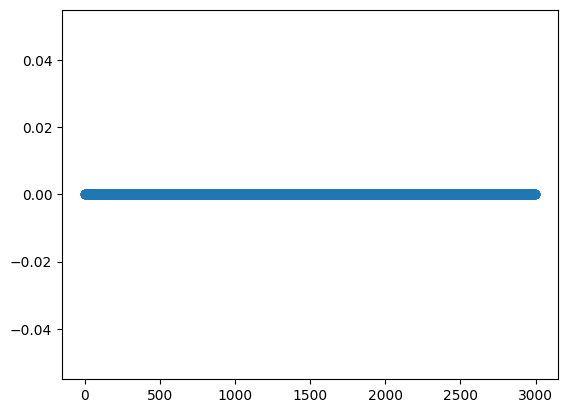

In [78]:
a = np.arange(0,3000)

plt.scatter(a, np.zeros_like(a))